In [1]:
import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import metrics
import StochasticGhost

def printmd(string):
    display(Markdown(string))
        
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.preprocessing import StandardScaler  

Analysis of Adult Income dataset with standard optimization algorithm without incorporating any fairness measures.

In [2]:
#adult = pd.read_csv('adult.csv')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num','marital-status', 'occupation', 'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']

adult = pd.read_csv('adult.data', names=column_names)

In [3]:
############# If you want to drop the missing value rows ################
mask = adult.eq(' ?')
mask.sum()
adult = adult.drop(adult.index[mask.any(axis=1)]).reset_index(drop=True)
len(adult)

# Setting all the categorical columns to type category
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')


adult['hour_worked_bins'] = ['<40' if i < 40 else '40-60' if i <= 60 else '>60'  for i in adult['hours-per-week']]
adult['hour_worked_bins'] = adult['hour_worked_bins'].astype('category')

In [4]:
# Create one hot encoding of the categorical columns in the data frame.
def oneHotCatVars(df, df_cols):
    
    df_1 = adult_data = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))


In [5]:
SENSITIVE_CODE_0 = 0
SENSITIVE_CODE_1 = 1

gender_mapping = {' Male': SENSITIVE_CODE_0, ' Female': SENSITIVE_CODE_1}

adult_new = adult.copy()
print("Unique values in 'gender' column in the new DataFrame:", adult_new['gender'].unique())

Unique values in 'gender' column in the new DataFrame: [' Male', ' Female']
Categories (2, object): [' Female', ' Male']


In [6]:
# Create a new column 'race_code' based on the mapping
adult_new['gender_code'] = adult_new['gender'].map(gender_mapping)

income_mapping = {' >50K': 1, ' <=50K': 0}
adult_new['income_code'] = adult_new['income'].map(income_mapping)

adult_new['education_code'] = pd.Categorical(adult_new['education']).codes
adult_new['marital_code'] = pd.Categorical(adult_new['marital-status']).codes
adult_new['occupation_code'] = pd.Categorical(adult_new['occupation']).codes
adult_new['relationship_code'] = pd.Categorical(adult_new['relationship']).codes
adult_new['race_code'] = pd.Categorical(adult_new['race']).codes
adult_new['country_code'] = pd.Categorical(adult_new['native-country']).codes
adult_new['hours_code'] = pd.Categorical(adult_new['hour_worked_bins']).codes

in_cols = ['education_code', 'marital_code', 'gender_code', 'occupation_code', 'relationship_code', 'race_code', 'country_code', 'hours_code']
out_cols = ['income_code']

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(torch.tensor(adult_new[in_cols].values), torch.tensor(adult_new[out_cols].values), test_size=0.3, random_state=42)

In [8]:
class SimpleClassifier(nn.Module):
    def __init__(self, layer_sizes):
        super(SimpleClassifier, self).__init__()

        # Create a list of linear layers based on layer_sizes
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu((layer(x)))
        x = torch.sigmoid(self.layers[-1](x))
        return x

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_val)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/tmp/ipykernel_62085/1797719004.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
/tmp/ipykernel_62085/1797719004.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(Y_val, dtype=torch.float32)


In [10]:
# Instantiate the model
input_size = X_train.shape[1]
hidden_size1 = 16
hidden_size2 = 16
op_size = 1
layer_sizes = [input_size, hidden_size1, hidden_size2, op_size]
model = SimpleClassifier(layer_sizes)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500

In [11]:
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/500, Loss: 0.3984375596046448
Epoch 2/500, Loss: 0.40065091848373413
Epoch 3/500, Loss: 0.35655808448791504
Epoch 4/500, Loss: 0.6362667679786682
Epoch 5/500, Loss: 0.42702630162239075
Epoch 6/500, Loss: 0.3372008204460144
Epoch 7/500, Loss: 0.4616473913192749
Epoch 8/500, Loss: 0.37901708483695984
Epoch 9/500, Loss: 0.44526079297065735
Epoch 10/500, Loss: 0.36077576875686646
Epoch 11/500, Loss: 0.39921677112579346
Epoch 12/500, Loss: 0.45393678545951843
Epoch 13/500, Loss: 0.4016158878803253
Epoch 14/500, Loss: 0.307721346616745
Epoch 15/500, Loss: 0.37262681126594543
Epoch 16/500, Loss: 0.4506610929965973
Epoch 17/500, Loss: 0.37862810492515564
Epoch 18/500, Loss: 0.5803756713867188
Epoch 19/500, Loss: 0.31389951705932617
Epoch 20/500, Loss: 0.3291541337966919
Epoch 21/500, Loss: 0.4821748435497284
Epoch 22/500, Loss: 0.6092081069946289
Epoch 23/500, Loss: 0.3847864270210266
Epoch 24/500, Loss: 0.3797965943813324
Epoch 25/500, Loss: 0.3418349325656891
Epoch 26/500, Loss: 0.42

In [12]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    pred = []
    lab = []
    x_val = []
    out = []
    x_scaled = []
    start = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = (outputs >= 0.5).float()
        total += labels.size(0)
        end = start + len(labels)
        x_val.append(X_val[start:end, :])
        x_scaled.append(inputs)
        pred.append(predictions.flatten())
        lab.append(labels.flatten())
        out.append(outputs.flatten().float())
        correct += (predictions == labels.view(-1, 1)).sum().item()
        start = end
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 81.82%


In [13]:
pred = torch.cat(pred, dim=0)
lab = torch.cat(lab, dim=0)
out = torch.cat(out, dim=0)
tensor_list = []
for i in range(len(x_val)):
    for ip_ten in (x_val[i]):
      tensor_list.append(np.array(ip_ten))
tensor_list = np.array(tensor_list)
pred = np.array(pred)
lab = np.array(lab)
out = np.array(out)

In [14]:
tensor_list_scaled = []
for i in range(len(x_scaled)):
    for ip_ten in (x_scaled[i]):
      tensor_list_scaled.append(np.array(ip_ten))
tensor_list_scaled = np.array(tensor_list_scaled)

In [15]:
df_out_scaled = pd.DataFrame(tensor_list_scaled, columns=['education_code', 'marital_code', 'gender_code', 'occupation_code', 'relationship_code', 'race_code', 'country_code', 'hours_code'])
df_out_scaled["raw_out"] = (out)
df_out_scaled["true_labels"] = (lab).astype(int)

In [16]:
df_out = pd.DataFrame(tensor_list, columns=['education_code', 'marital_code', 'gender_code', 'occupation_code', 'relationship_code', 'race_code', 'country_code', 'hours_code'])
df_out["pred_labels"] = (pred).astype(int)
df_out["true_labels"] = (lab).astype(int)

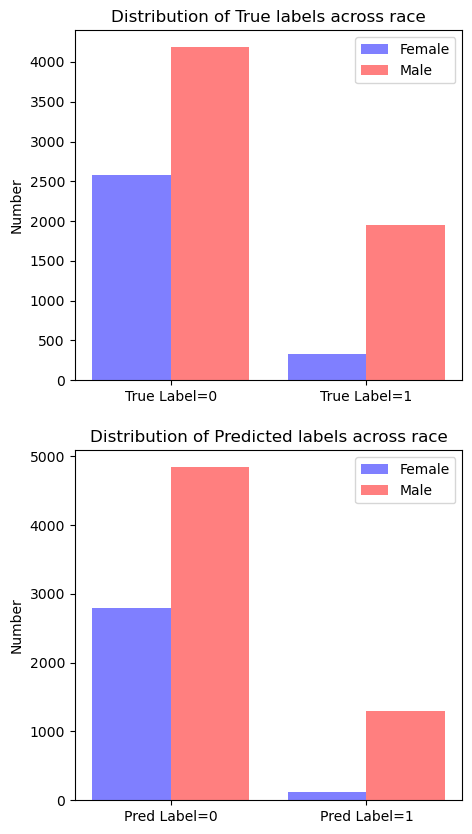

In [17]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = ['True Label=0', 'True Label=1']
values1 = [len(df_out[(df_out["gender_code"]==1) & (df_out["true_labels"]==0)]), len(df_out[(df_out["gender_code"]==1) & (df_out["true_labels"]==1)])]
values2 = [len(df_out[(df_out["gender_code"]==0) & (df_out["true_labels"]==0)]), len(df_out[(df_out["gender_code"]==0) & (df_out["true_labels"]==1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
        label='Female', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
        width=bar_width, label='Male', alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)
# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Number")
ax[0].set_title('Distribution of True labels across race')
ax[0].legend()


categories2 = ['Pred Label=0', 'Pred Label=1']
values3 = [len(df_out[(df_out["gender_code"]==1) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["gender_code"]==1) & (df_out["pred_labels"]==1)])]
values4 = [len(df_out[(df_out["gender_code"]==0) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["gender_code"]==0) & (df_out["pred_labels"]==1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
        label='Female', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
        width=bar_width, label='Male', alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)
# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Number")
ax[1].set_title('Distribution of Predicted labels across race')
ax[1].legend()


In [ ]:
tp_female = df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 1)]
fp_female = df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 1)]
tn_female = df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 1)]
fn_female = df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 1)]

tp_male = df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 0)]
fp_male = df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 0)]
tn_male = df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 0)]
fn_male = df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 0)]